<a href="https://colab.research.google.com/github/jameslequang232/Machine_Learning_Tool_for_Insomnia_Screening_Using_NHANES_Data/blob/main/Machine_Learning_Tool_for_Insomnia_Screening_Using_NHANES_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Hello My Names Is James Lequang, and this is my lovely machine learning tool for insomnia screening that I created!

In [1]:
from google.colab import files
uploaded = files.upload()

Saving P_ALQ.xpt to P_ALQ.xpt
Saving P_BIOPRO.XPT to P_BIOPRO.XPT
Saving P_BMX.XPT to P_BMX.XPT
Saving P_BPQ.xpt to P_BPQ.xpt
Saving P_DBQ.xpt to P_DBQ.xpt
Saving P_DEMO.xpt to P_DEMO.xpt
Saving P_DIQ.xpt to P_DIQ.xpt
Saving P_DPQ.xpt to P_DPQ.xpt
Saving P_DR1TOT.XPT to P_DR1TOT.XPT
Saving P_GLU.XPT to P_GLU.XPT
Saving P_HSQ.xpt to P_HSQ.xpt
Saving P_MCQ.xpt to P_MCQ.xpt
Saving P_PAQ.xpt to P_PAQ.xpt
Saving P_RXQ_RX.xpt to P_RXQ_RX.xpt
Saving P_SLQ.xpt to P_SLQ.xpt
Saving P_SMQFAM.xpt to P_SMQFAM.xpt
Saving RXQ_DRUG.xpt to RXQ_DRUG.xpt


In [2]:
 !pip install optuna --upgrade shap xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 31.0 MB/s eta 0:00:00


In [24]:

import pandas as pd
import numpy as np
import optuna
import shap
import joblib
import json
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    make_scorer,
    precision_recall_curve,
    classification_report
)
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek


def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)



# 1. Load & Merge NHANES Data


print("Loading SAS files...")
df_demo = pd.read_sas("/content/P_DEMO.xpt")
df_sleep = pd.read_sas("/content/P_SLQ.xpt")
df_dpq = pd.read_sas("/content/P_DPQ.xpt")
df_mcq = pd.read_sas("/content/P_MCQ.xpt")
df_bpq = pd.read_sas("/content/P_BPQ.xpt")
df_rxq = pd.read_sas("/content/P_RXQ_RX.xpt")
df_alq = pd.read_sas("/content/P_ALQ.xpt")
df_bmx = pd.read_sas("/content/P_BMX.XPT")
df_smq = pd.read_sas("/content/P_SMQFAM.xpt")
df_paq = pd.read_sas("/content/P_PAQ.xpt")
df_glu = pd.read_sas("/content/P_GLU.XPT")
df_dbq = pd.read_sas("/content/P_DBQ.xpt")
df_diet = pd.read_sas("/content/P_DR1TOT.XPT")
df_bio = pd.read_sas("/content/P_BIOPRO.XPT")


# 2. Feature Engineering

dpq_cols = [f"DPQ0{i}" for i in range(20, 100, 10)]

dpq_cols = [c for c in dpq_cols if c in df_dpq.columns]
df_dpq["phq9_total"] = df_dpq[dpq_cols].sum(axis=1, skipna=True)
dpq_reduced = df_dpq[["SEQN", "phq9_total"] + dpq_cols] if len(dpq_cols) else df_dpq[["SEQN", "phq9_total"]]
# SEQN is the NHANES participants' ID needed to merge datasets!
df_paq = df_paq[["SEQN", "PAQ605", "PAD615", "PAD630"]].copy()
df_paq = df_paq.rename(columns={"PAQ605": "activity_limited"})

df_sleep = df_sleep.rename(
    columns={
        "SLD012": "weekday_sleep_hours",
        "SLD013": "weekend_sleep_hours",
        "SLQ030": "work_shift",
        "SLQ040": "works_night_shift",
        "SLQ050": "trouble_sleeping",
        "SLQ120": "sleep_disorder",
    }
)

df = df_demo.copy()
merge_tables = [
    df_sleep,
    dpq_reduced,
    df_mcq,
    df_alq,
    df_bmx,
    df_smq,
    df_paq,
    df_dbq,
    df_diet,
    df_bio,
    df_glu,
    df_bpq,
    df_rxq,
]
for t in merge_tables:

    if "SEQN" in t.columns:
        df = df.merge(t, on="SEQN", how="left")


# 3. Target Label

df = df[df["trouble_sleeping"].notna()].copy()
df["insomnia"] = df["trouble_sleeping"].apply(lambda x: 1 if x == 1 else 0)


# 4. Medication Features

def safe_lower(x):
    if isinstance(x, bytes):
        try:
            return x.decode("utf-8").lower()
        except Exception:
            return str(x).lower()
    return str(x).lower()

if "RXDDRUG" in df.columns:
    df["RXDDRUG"] = df["RXDDRUG"].apply(lambda x: safe_lower(x) if pd.notna(x) else "")
else:
    df["RXDDRUG"] = ""

sleep_meds = [
    "zolpidem",
    "ambien",
    "trazodone",
    "melatonin",
    "temazepam",
    "diphenhydramine",
    "doxylamine",
    "eszopiclone",
    "lunesta",
    "ramelteon",
]
antidepressants = [
    "fluoxetine",
    "sertraline",
    "venlafaxine",
    "citalopram",
    "escitalopram",
]
if "RXDDRUG" in df.columns:
    df_rx = df.groupby("SEQN")["RXDDRUG"].apply(lambda x: " ".join(x.dropna())).reset_index()
    df_rx["takes_sleep_med"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in sleep_meds)))
    df_rx["takes_antidepressant"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in antidepressants)))
    df = df.merge(df_rx[["SEQN", "takes_sleep_med", "takes_antidepressant"]], on="SEQN", how="left")
else:
    df["takes_sleep_med"] = 0
    df["takes_antidepressant"] = 0


# 5. Feature Selection & Engineering

num_cols = [
    "RIDAGEYR",
    "INDFMPIR",
    "weekday_sleep_hours",
    "weekend_sleep_hours",
    "phq9_total",
    "BMXBMI",
    "BMXWAIST",
    "PAD615",
    "PAD630",
]

num_cols = [c for c in num_cols if c in df.columns]

if "RIDAGEYR" in df.columns and "BMXBMI" in df.columns:
    df["age_bmi"] = df["RIDAGEYR"] * df["BMXBMI"]
    num_cols.append("age_bmi")

if "INDFMPIR" in df.columns and "BMXBMI" in df.columns:
    df["income_bmi"] = df["INDFMPIR"] / (df["BMXBMI"] + 1)
    num_cols.append("income_bmi")

if "phq9_total" in df.columns and "weekday_sleep_hours" in df.columns:
    df["depression_sleep"] = df["phq9_total"] + df["weekday_sleep_hours"]
    num_cols.append("depression_sleep")

if "DR1TCAFF" in df.columns and "RIDAGEYR" in df.columns:
    df["caff_age"] = df["DR1TCAFF"] * df["RIDAGEYR"]
    num_cols.append("caff_age")
else:
    df["caff_age"] = 0
    num_cols.append("caff_age")

extra_cols = [
    "DR1TKCAL",
    "DR1TPROT",
    "DR1TCARB",
    "DR1TTFAT",
    "DR1TSUGR",
    "DR1TSODI",
    "DR1TCHOL",
    "DR1TCAFF",
    "LBXSAL",
    "LBXSAPSI",
    "LBXSASSI",
    "LBXSCK",
    "LBXSCR",
    "LBXSUA",
]

extra_cols = [c for c in extra_cols if c in df.columns]


for col in extra_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)
    imputed = SimpleImputer(strategy="mean").fit_transform(df[[col]])

    try:
        scaled = StandardScaler().fit_transform(imputed)
    except Exception:
        scaled = imputed
    df[col] = scaled
    num_cols.extend([col, f"{col}_missing"])


cat_cols = [
    "RIAGENDR",
    "RIDRETH3",
    "DMDEDUC2",
    "MCQ160A",
    "ALQ130",
    "activity_limited",
    "work_shift",
    "works_night_shift",
]
cat_cols = [c for c in cat_cols if c in df.columns]
for col in cat_cols:

    df[col] = df[col].astype("category").cat.codes.fillna(-1).astype(int)


label_like = ["trouble_sleeping", "sleep_disorder", "SMD460", "SMD470"]
features = [c for c in (num_cols + cat_cols) if c not in label_like]

X = df[features].copy()
y = df["insomnia"].copy()


# 6. Split & Pre-impute

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

held_out = X_test.copy()
held_out["insomnia"] = y_test.values

held_out.to_csv("held_out_test_cases.csv", index=False)

print(f"Saved {len(held_out)} held-out test cases")


save_json("feature_names.json", list(X.columns))
save_json("feature_means.json", X.mean(numeric_only=True).to_dict())


imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

smt = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_imp, y_train)



# 8. Optuna hyperparameter tuning using F2 (fbeta beta=2) as CV scorer

f2_scorer = make_scorer(fbeta_score, beta=2)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "eval_metric": "logloss",
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(
        model, X_train_sm, y_train_sm,
        scoring=f2_scorer, cv=5
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
save_json("optuna_best_params.json", best_params)
joblib.dump(study, "optuna_study.pkl")



# 9. Train final pipeline


final_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
base_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])


print("Fitting raw pipeline on resampled train...")
base_pipeline.fit(X_train_sm, y_train_sm)

joblib.dump(base_pipeline, "xgb_pipeline_for_shap.joblib")
print("Saved raw pipeline for SHAP: xgb_pipeline_for_shap.joblib")


# 10. Calibratation

calibrated_model = CalibratedClassifierCV(
    base_pipeline,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train_sm, y_train_sm)


# Evaluate probabilities on test set
y_proba = calibrated_model.predict_proba(X_test_imp)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba)

from sklearn.metrics import fbeta_score
import numpy as np

best_threshold = None
best_f2 = -1

for threshold in np.linspace(0.05, 0.95, 181):
    y_pred = (y_proba >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"Best threshold (F2 tuned) = {best_threshold:.4f}, F2 = {best_f2:.4f}")



save_json("best_threshold_f2.json", {
    "threshold": float(best_threshold),
    "f2": float(best_f2)
})



# Final predictions & report
y_pred = (y_proba >= best_threshold).astype(int)
print("\nClassification report of Machine Learning Model at F2-optimal threshold:")
print(classification_report(y_test, y_pred))





# 12. Save calibrated model, threshold, metadata

joblib.dump(calibrated_model, "xgb_insomnia_model.joblib")
save_json("best_threshold_f2.json", {"best_threshold_f2": float(best_threshold), "best_f2": float(best_f2)})
print("Saved calibrated model and threshold.")


meta = {
    "features": list(X.columns),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "optuna_best_params": best_params,
    "best_threshold_f2": float(best_threshold),
    "best_f2_on_test": float(best_f2),
}
save_json("training_metadata.json", meta)


# 13. SHAP analysis

print("Running SHAP analysis (TreeExplainer on final raw XGBoost model)...")
xgb_model = calibrated_model.estimator.named_steps["xgb"]

X_shap = X_train.sample(min(2000, len(X_train)), random_state=42)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["imputer"].transform(X_shap),
    columns=X.columns
)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["scaler"].transform(X_shap),
    columns=X.columns
)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

joblib.dump(explainer, "shap_explainer.joblib")
joblib.dump(shap_values, "shap_values.joblib")

mean_abs = np.abs(shap_values).mean(axis=0)
pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)\
 .to_csv("shap_feature_importance.csv", index=False)


for i in range (3,0,-1):
  print(i, end=" ")
print("Saved everything! And that is my machine learning model")



Loading SAS files...
Saved 5379 held-out test cases


[I 2026-01-22 01:54:37,619] A new study created in memory with name: no-name-fde3eb02-f3e9-4a1b-8542-c325c2edd469
[I 2026-01-22 01:54:48,316] Trial 0 finished with value: 0.933625325954597 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.17432484504603382, 'subsample': 0.6765054846818473, 'colsample_bytree': 0.9764074428951082, 'gamma': 0.9836394200061349, 'min_child_weight': 7, 'reg_alpha': 0.7087325502767022, 'reg_lambda': 2.3874227255210965}. Best is trial 0 with value: 0.933625325954597.
[I 2026-01-22 01:54:56,948] Trial 1 finished with value: 0.9041357950191985 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.12826902551009112, 'subsample': 0.950934331716915, 'colsample_bytree': 0.9988984796905658, 'gamma': 0.039606148052612866, 'min_child_weight': 10, 'reg_alpha': 3.023932897938625, 'reg_lambda': 0.6943434114991531}. Best is trial 0 with value: 0.933625325954597.
[I 2026-01-22 01:55:02,063] Trial 2 finished with value: 0.91343895860

Fitting raw pipeline on resampled train...
Saved raw pipeline for SHAP: xgb_pipeline_for_shap.joblib
Best threshold (F2 tuned) = 0.3450, F2 = 0.9316

Classification report of Machine Learning Model at F2-optimal threshold:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3166
           1       0.92      0.93      0.93      2213

    accuracy                           0.94      5379
   macro avg       0.94      0.94      0.94      5379
weighted avg       0.94      0.94      0.94      5379

Saved calibrated model and threshold.
Running SHAP analysis (TreeExplainer on final raw XGBoost model)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


3 2 1 Saved everything! And that is my machine learning model


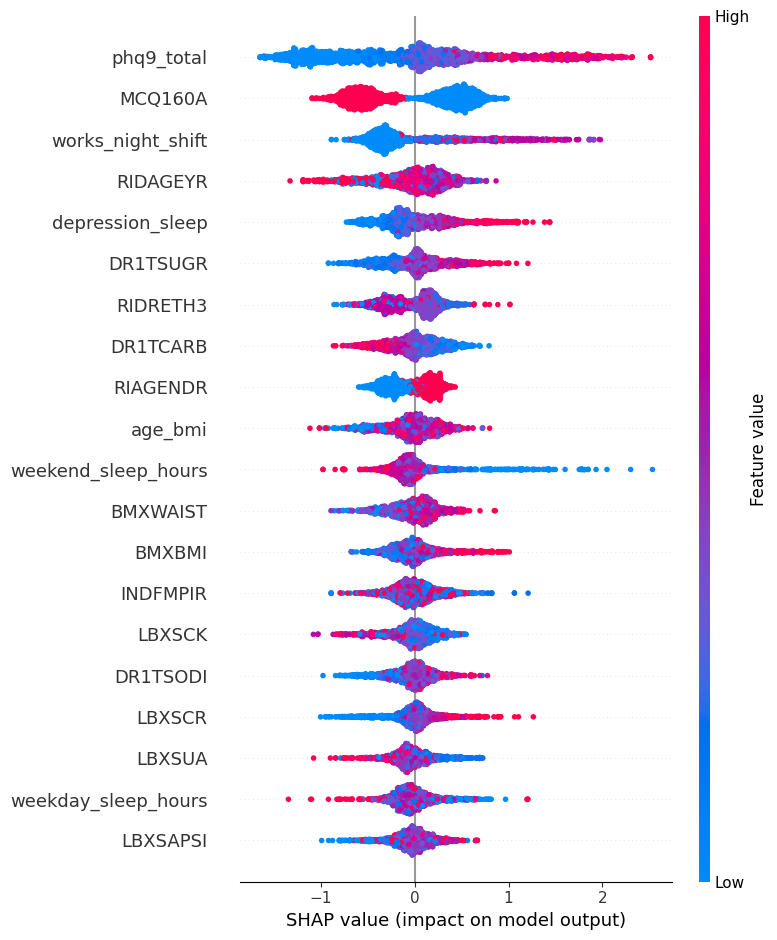

In [ ]:
shap.summary_plot(shap_values, X_shap, feature_names=X_train.columns)

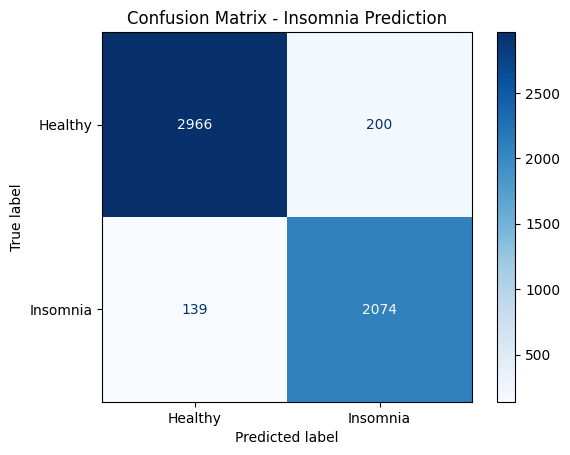

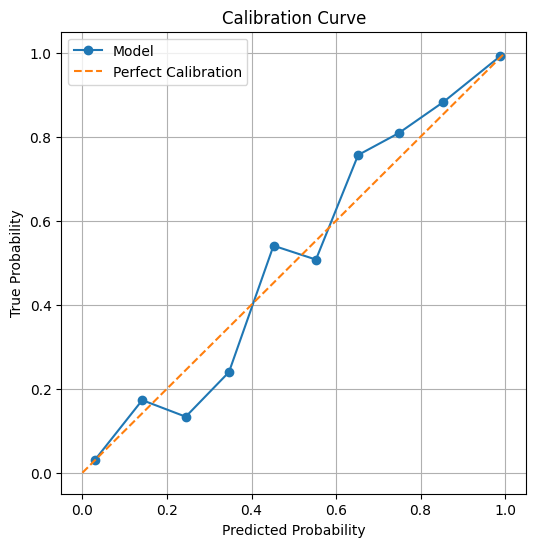

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve # Corrected import

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Insomnia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Insomnia Prediction")
plt.show()

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

**Training Model **

---

# XGB Optuna Model F2 Optimized

In [ ]:
from sklearn.metrics import brier_score_loss

# Calculate Brier score
brier_score = brier_score_loss(y_test, y_proba)
print(f'Brier Score: {brier_score}')

Brier Score: 0.04440024309746061


### ROC Curve and AUC

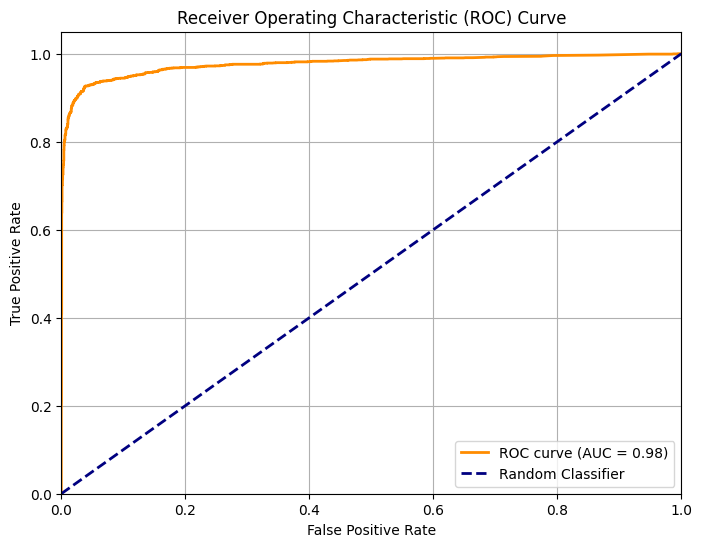

AUC Score: 0.977


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

### Precision-Recall Curve

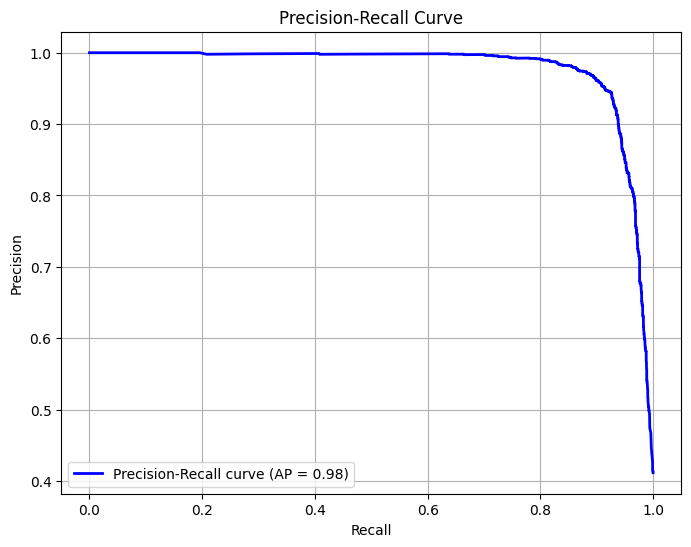

Average Precision (AP) Score: 0.977


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"Average Precision (AP) Score: {pr_auc:.3f}")

### SHAP Feature Importance Plot Ordered in importance from Top to Bottom

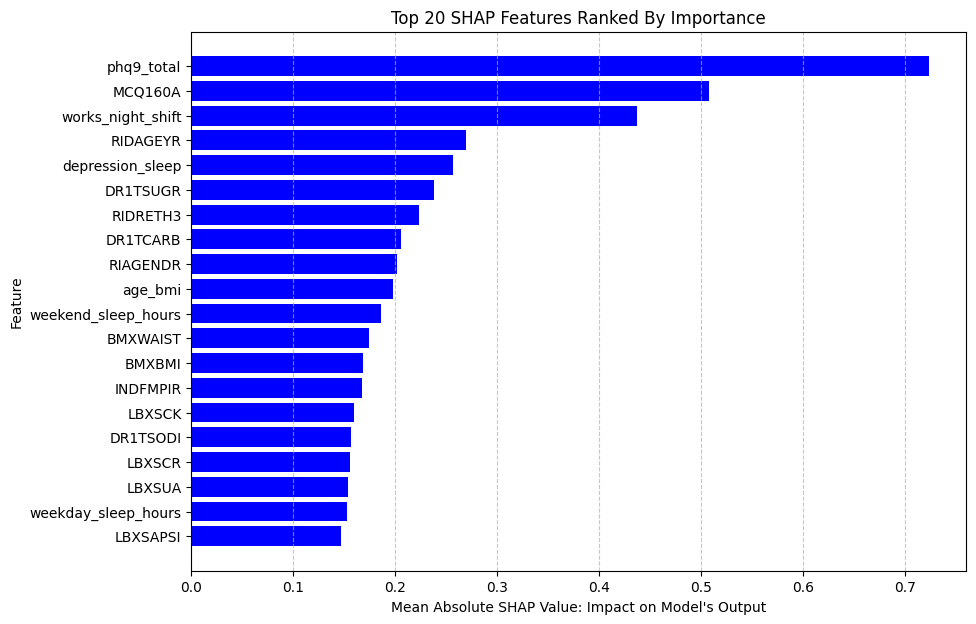

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


shap_values = joblib.load('shap_values.joblib')


import json
with open('feature_names.json', 'r') as f:
    feature_names = json.load(f)


mean_abs_shap = np.abs(shap_values).mean(axis=0)


shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
})


top_n = 20
top_features = shap_importance.sort_values(by='mean_abs_shap', ascending=False).head(top_n)

plt.figure(figsize=(10, 7))
plt.barh(top_features['feature'], top_features['mean_abs_shap'], color='blue')
plt.xlabel("Mean Absolute SHAP Value: Impact on Model's Output")
plt.ylabel('Feature')
plt.title(f'Top {top_n} SHAP Features Ranked By Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import json
with open("features_used.json", "w") as f:
    json.dump(features, f)


In [ ]:
import matplotlib.pyplot as plt
print (X_test)
X_test.to_csv("X_test.csv", index=False)


       RIDAGEYR  INDFMPIR  weekday_sleep_hours  weekend_sleep_hours  \
23392      68.0      1.04                  5.5                  7.0   
21217      70.0      1.76                  8.0                  8.0   
22260      71.0      1.44                  7.0                  7.0   
24515      66.0      2.96                  6.0                  8.0   
2790       80.0      5.00                  9.0                  9.0   
...         ...       ...                  ...                  ...   
18647      63.0      1.76                  8.0                  8.0   
11327      70.0      1.45                  7.0                  7.0   
11645      19.0       NaN                 11.0                 11.0   
1927       23.0       NaN                  7.0                  7.0   
1127       55.0      3.79                  7.0                  7.0   

         phq9_total  BMXBMI  BMXWAIST  PAD615  PAD630  age_bmi  ...    LBXSUA  \
23392  4.000000e+00    22.2      84.2     NaN    90.0   1509.6  ..

In [ ]:
import matplotlib.pyplot as plt
print (y_test)
y_test.to_csv("y_test.csv", index=False)


23392    1
21217    1
22260    0
24515    1
2790     1
        ..
18647    0
11327    0
11645    1
1927     1
1127     1
Name: insomnia, Length: 5379, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
print (df)
df.to_csv("full_dataset.csv", index=False)




           SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      109266.0      66.0       2.0         1      29.0       NaN       5.0   
1      109267.0      66.0       1.0         1      21.0       NaN       2.0   
2      109268.0      66.0       1.0         1      18.0       NaN       3.0   
3      109271.0      66.0       2.0         0      49.0       NaN       3.0   
4      109271.0      66.0       2.0         0      49.0       NaN       3.0   
...         ...       ...       ...       ...       ...       ...       ...   
26888  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26889  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26890  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26891  124822.0      66.0       2.0         0      74.0       NaN       2.0   
26892  124822.0      66.0       2.0         0      74.0       NaN       2.0   

       RIDRETH3  RIDEXMON  DMDBORN4  ...  DR1TSUGR_

In [ ]:
from google.colab import files
files. download("full_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading SAS files...


[I 2025-12-25 23:01:01,899] A new study created in memory with name: no-name-81b2befa-9083-4c92-8650-62143029002b
[I 2025-12-25 23:01:10,754] Trial 0 finished with value: 0.7327151200664112 and parameters: {'n_estimators': 387, 'max_depth': 3, 'learning_rate': 0.028200987362919698, 'subsample': 0.9167676760056178, 'colsample_bytree': 0.5835826094418498, 'gamma': 1.5430034166011881, 'min_child_weight': 9, 'reg_alpha': 4.6189915537377715, 'reg_lambda': 1.2207763291729945}. Best is trial 0 with value: 0.7327151200664112.
[I 2025-12-25 23:01:18,122] Trial 1 finished with value: 0.8953136832768193 and parameters: {'n_estimators': 555, 'max_depth': 7, 'learning_rate': 0.18752836053413274, 'subsample': 0.6372747041978781, 'colsample_bytree': 0.7933969779592138, 'gamma': 1.4668192742869555, 'min_child_weight': 8, 'reg_alpha': 3.4811404127749794, 'reg_lambda': 1.2856948490834048}. Best is trial 1 with value: 0.8953136832768193.
[I 2025-12-25 23:01:22,696] Trial 2 finished with value: 0.88780156

Fitting raw pipeline on resampled train...
Saved raw pipeline for SHAP: xgb_pipeline_for_shap.joblib
Best threshold (F2 tuned) = 0.2350, F2 = 0.9328

Classification report at F2-optimal threshold:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3166
           1       0.90      0.94      0.92      2213

    accuracy                           0.93      5379
   macro avg       0.93      0.93      0.93      5379
weighted avg       0.93      0.93      0.93      5379

Saved calibrated model and threshold.
Running SHAP analysis (TreeExplainer on final raw XGBoost model)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


SHAP saved to shap/
All done. Saved artifacts 


In [ ]:
print("best_threshold exists:", "best_threshold" in globals())
print("best_f2 exists:", "best_f2" in globals())


best_threshold exists: True
best_f2 exists: True


In [ ]:
import requests
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

API_URL = "http://127.0.0.1:9006/docs#/default/predict_predict_post"

# Load labeled test data
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")["insomnia"]

probs = []
preds = []

def sanitize_for_json(d):
    clean = {}
    for k, v in d.items():
        if v is None:
            clean[k] = None
        elif isinstance(v, (float, np.floating)):
            if np.isnan(v) or np.isinf(v):
                clean[k] = None
            else:
                clean[k] = float(v)
        else:
            clean[k] = v
    return clean


for _, row in X_test.iterrows():
    payload = sanitize_for_json(payload)

    response = requests.post(
      "http://127.0.0.1:8000/predict",
      json=payload
    )


    probs.append(response["insomnia_probability"])
    preds.append(response["predicted_label"])

# Metrics
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1:", f1_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


NameError: name 'payload' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv("full_dataset.csv")
df.columns.tolist()


['SEQN',
 'SDDSRVYR',
 'RIDSTATR',
 'RIAGENDR',
 'RIDAGEYR',
 'RIDAGEMN',
 'RIDRETH1',
 'RIDRETH3',
 'RIDEXMON',
 'DMDBORN4',
 'DMDYRUSZ',
 'DMDEDUC2',
 'DMDMARTZ',
 'RIDEXPRG',
 'SIALANG',
 'SIAPROXY',
 'SIAINTRP',
 'FIALANG',
 'FIAPROXY',
 'FIAINTRP',
 'MIALANG',
 'MIAPROXY',
 'MIAINTRP',
 'AIALANGA',
 'WTINTPRP',
 'WTMECPRP',
 'SDMVPSU',
 'SDMVSTRA',
 'INDFMPIR',
 'SLQ300',
 'SLQ310',
 'weekday_sleep_hours',
 'SLQ320',
 'SLQ330',
 'weekend_sleep_hours',
 'work_shift',
 'works_night_shift',
 'trouble_sleeping',
 'sleep_disorder',
 'phq9_total',
 'DPQ020',
 'DPQ030',
 'DPQ040',
 'DPQ050',
 'DPQ060',
 'DPQ070',
 'DPQ080',
 'DPQ090',
 'MCQ010',
 'MCQ025',
 'MCQ035',
 'MCQ040',
 'MCQ050',
 'AGQ030',
 'MCQ053',
 'MCQ080',
 'MCQ092',
 'MCD093',
 'MCQ149',
 'MCQ151',
 'RHD018',
 'MCQ160A',
 'MCQ195',
 'MCQ160B',
 'MCD180B',
 'MCQ160C',
 'MCD180C',
 'MCQ160D',
 'MCD180D',
 'MCQ160E',
 'MCD180E',
 'MCQ160F',
 'MCD180F',
 'MCQ160M',
 'MCQ170M',
 'MCD180M',
 'MCQ160P',
 'MCQ160L',
 'MCQ170L',
 

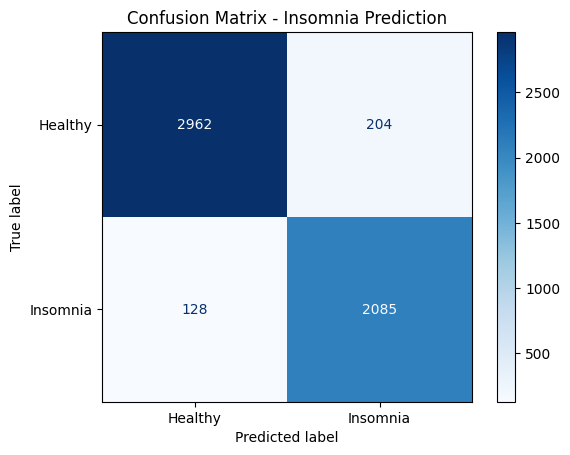

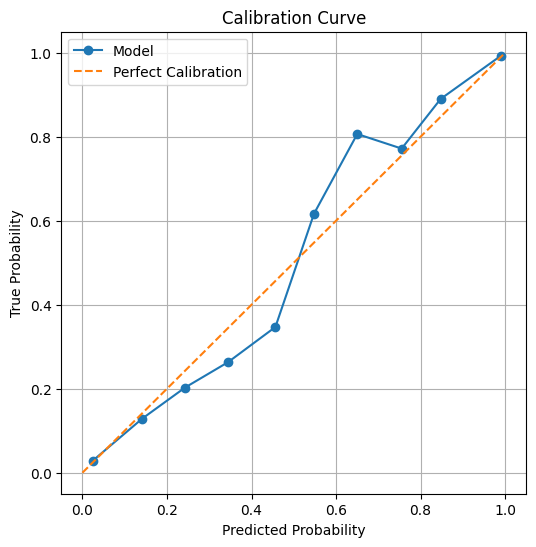

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve # Corrected import

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Insomnia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Insomnia Prediction")
plt.show()

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
 !pip install fastapi uvicorn joblib streamlit


# Deployment


In [ ]:
 #- Desciptions for Main.py -#

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",

SyntaxError: illegal target for annotation (ipython-input-2436844742.py, line 3)

In [ ]:
import pandas as pd
import json

with open ("features_used.json", "r") as f:
  features = json.load(f)

X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df.head(100).to_csv("X_train_sample.csv", index= False)
print("Saved X_train_sample.csv with shape", X_train_df.head(100).shape)

Saved X_train_sample.csv with shape (100, 49)


In [ ]:
import pandas as pd
import joblib

# Suppose X_raw is your original DataFrame
numeric_means = df.select_dtypes(include=["number"]).mean().to_dict()

# For categorical features → use mode
categorical_modes = {
    col: df[col].mode()[0]
    for col in df.select_dtypes(exclude=["number"]).columns
}

# Merge them
feature_defaults = {**numeric_means, **categorical_modes}

# Save
joblib.dump(feature_defaults, "feature_means.pkl")



['feature_means.pkl']

In [ ]:
feature_names = [
    "RIDAGEYR", "INDFMPIR", "weekday_sleep_hours", "weekend_sleep_hours",
    "phq9_total", "BMXBMI", "BMXWAIST",
    "PAD615", "PAD630",
    "age_bmi", "income_bmi", "depression_sleep", "caff_age",
    "DR1TKCAL", "DR1TKCAL_missing",
    "DR1TPROT", "DR1TPROT_missing",
    "DR1TCARB", "DR1TCARB_missing",
    "DR1TTFAT", "DR1TTFAT_missing",
    "DR1TSUGR", "DR1TSUGR_missing",
    "DR1TSODI", "DR1TSODI_missing",
    "DR1TCHOL", "DR1TCHOL_missing",
    "DR1TCAFF", "DR1TCAFF_missing",
    "LBXSAL", "LBXSAL_missing",
    "LBXSAPSI", "LBXSAPSI_missing",
    "LBXSASSI", "LBXSASSI_missing",
    "LBXSCK", "LBXSCK_missing",
    "LBXSCR", "LBXSCR_missing",
    "LBXSUA", "LBXSUA_missing",
    "RIAGENDR", "RIDRETH3", "DMDEDUC2",
    "MCQ160A", "ALQ130",
    "activity_limited", "work_shift", "works_night_shift"
]
joblib.dump(feature_names, "clean_feature_names.pkl")

['clean_feature_names.pkl']

In [ ]:
import pickle

# Load existing feature means
with open("feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

with open("clean_feature_names.pkl", "rb") as f:
    clean_feature_names = pickle.load(f)

# Optionally, filter or modify it here
# e.g., keep only the 52 features your model expects
filtered_means = {k: v for k, v in feature_means.items() if k in clean_feature_names}

# Save under a new name
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(feature_means, f)

print("✅ Saved feature means as feature_means_49.pkl")


In [ ]:
import pickle

# Load your existing means
with open("feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

# Keep only the 52 features the model expects
filtered_means = {k: v for k, v in feature_means.items() if k in feature_names}

print(len(filtered_means))  # should now be 52

# Save it back if you want
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(filtered_means, f)


49


In [ ]:
import pickle

# Load your existing means
with open("feature_means_52.pkl", "rb") as f:
    feature_means_52 = pickle.load(f)

# Keep only the 52 features the model expects
filtered_means = {k: v for k, v in feature_means_52.items() if k in feature_names}

print(len(filtered_means))  # should now be 52

# Save it back if you want
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(filtered_means, f)


49


In [ ]:
# clean_feature_means.py
import joblib
import numpy as np

def convert_time_to_minutes(value):
    """Convert 'HH:MM' strings/bytes to minutes; keep numerics as-is."""
    if isinstance(value, (bytes, bytearray)):
        value = value.decode("utf-8")
    if isinstance(value, str) and ":" in value:
        try:
            h, m = map(int, value.split(":"))
            return h * 60 + m
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

print("🔹 Loading feature_means.pkl ...")
feature_means = joblib.load("feature_means.pkl")

cleaned = {k: convert_time_to_minutes(v) for k, v in feature_means.items()}

print("✅ Cleaned. Example values:")
for k, v in list(cleaned.items())[:10]:
    print(f"{k}: {v}")

joblib.dump(cleaned, "feature_means.pkl")
print("💾 Saved cleaned feature_means.pkl")


🔹 Loading feature_means.pkl ...
✅ Cleaned. Example values:
SEQN: 117067.44130442866
SDDSRVYR: 66.0
RIDSTATR: 1.9272301342356748
RIAGENDR: 0.5264566987691964
RIDAGEYR: 57.59442977726546
RIDAGEMN: nan
RIDRETH1: 3.255903023091511
RIDRETH3: 2.3098203993604285
RIDEXMON: 1.491738851459737
DMDBORN4: 1.239876547800543
💾 Saved cleaned feature_means.pkl


In [ ]:
import pickle

# Load your full feature means
with open("feature_means_52.pkl", "rb") as f:
    feature_means = pickle.load(f)

# Suppose this is your 52-feature list
with open("clean_feature_names.pkl", "rb") as f:
    feature_names_52 = pickle.load(f)

# Keep only the 52 features your model expects
filtered_means = {k: feature_means[k] for k in feature_names if k in feature_means}

# Save as a new pickle file
with open("cleaned_feature_means.pkl", "wb") as f:
    pickle.dump(filtered_means, f)

print(f"✅ Saved {len(filtered_means)} feature means to 'cleaned_feature_means.pkl'")


✅ Saved 49 feature means to 'cleaned_feature_means.pkl'


In [ ]:
# main.py
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import numpy as np
import joblib
import json

app = FastAPI(
    title="Insomnia Prediction API - By James Lequang",
    summary="Recall-Optimized Machine Learning Model for Insomnia Diagnosis",
    description="""
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!
""",
)

# 1. Load artifacts

model = joblib.load("xgb_insomnia_model.joblib")
explainer = joblib.load("shap_explainer.joblib")

with open("feature_names.json") as f:
    feature_names = json.load(f)

with open("feature_means.json") as f:
    feature_means = json.load(f)

with open("best_threshold_f2.json") as f:
    thresh_data = json.load(f)
    best_threshold = thresh_data["best_threshold_f2"]


print(f"Loaded model with {len(feature_names)} features")
print(f"F2 threshold = {best_threshold:.4f}")

# --------------------------------------------------
# 2. Feature descriptions (optional, UI only)
# --------------------------------------------------
feature_descriptions = {
 #- Desciptions for Main.py -#

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",
}

# --------------------------------------------------
# 3. Dynamic Pydantic input model
# --------------------------------------------------
fields = {}
for name in feature_names:
    default = feature_means.get(name, np.nan)
    desc = feature_descriptions.get(name, name)

    fields[name] = (
        float,
        Field(default=float(default) if default == default else None,
              description=desc)
    )

InsomniaInput = create_model("InsomniaInput", **fields)

# --------------------------------------------------
# 4. Endpoints
# --------------------------------------------------
@app.get("/")
def root():
    return {"status": "Insomnia Prediction API is running"}

@app.get("/features")
def list_features():
    return {
        "features": [
            {
                "name": f,
                "default": feature_means.get(f),
                "description": feature_descriptions.get(f, "")
            }
            for f in feature_names
        ]
    }


import numpy as np

def sanitize_for_json(d):
    clean = {}
    for k, v in d.items():
        if v is None:
            clean[k] = None
        elif isinstance(v, (float, np.floating)):
            if np.isnan(v) or np.isinf(v):
                clean[k] = None
            else:
                clean[k] = float(v)
        else:
            clean[k] = v
    return clean

@app.post("/predict")
def predict(payload: InsomniaInput):


    # ------------------------
    # 1. Build input dataframe
    # ------------------------
    row = {
        f: getattr(payload, f, feature_means.get(f))
        for f in feature_names
    }
    df = pd.DataFrame([row], columns=feature_names)

    # 2. Detect all-mean input
    input_dict = payload.dict()

    all_mean_input = True
    for name in feature_names:
        try:
            if float(input_dict.get(name, feature_means[name])) != float(feature_means[name]):
                all_mean_input = False
                break
        except Exception:
            all_mean_input = False
            break

    guidance_note = (
        "Warning: All values are defaults averages! "
        "This can produce very high insomnia probabilities because the model "
        "is optimized for recall and detects population-level risk."
        if all_mean_input
        else
            "Remember this is just what the machine learning model believes, so please take this into light consideration! "

    )

    # ------------------------
    # 2. Predict probability
    # ------------------------
    proba = float(model.predict_proba(df)[0, 1])
    label = int(proba >= best_threshold)

    def risk_band(proba: float) -> str:
      if proba < 0.30:
        return "low"
      elif proba < 0.60:
        return "moderate"
      else:
        return "high"


    # ------------------------
    # 3. SHAP explanation
    # ------------------------
    base_pipeline = model.estimator
    X_trans = base_pipeline.named_steps["imputer"].transform(df)
    X_trans = base_pipeline.named_steps["scaler"].transform(X_trans)

    shap_vals = explainer.shap_values(X_trans)[0]

    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals)
    })

    top_features = (
        shap_df.sort_values("abs_shap", ascending=False)
        .head(5)
        .to_dict(orient="records")
    )

    # ------------------------
    # 4. Return response
    # ------------------------
    risk = risk_band(proba)

    return {
      "insomnia_probability": float(proba),
      "predicted_label": int(proba >= best_threshold),
      "threshold_used": best_threshold,
      "risk_band": risk,
      "top_shap_features": top_features
}


Loaded model with 49 features
F2 threshold = 0.2700


In [ ]:
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!

In [ ]:
# Correct way
y_proba = model.predict_proba(X_test)[:, 1]

print("y_proba shape:", y_proba.shape)


y_proba shape: (5379,)


In [ ]:
import numpy as np

y_proba = np.asarray(y_proba)
y_test = np.asarray(y_test)

y_pred = (y_proba >= best_threshold).astype(int)

print("Unique predictions:", np.unique(y_pred))


Unique predictions: [0 1]


In [ ]:
print(type(y_proba), y_proba.shape)
print(type(y_test), y_test.shape)
print("Unique predictions:", np.unique(y_pred))


<class 'numpy.ndarray'> (5379,)
<class 'numpy.ndarray'> (5379,)
Unique predictions: [0 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary"
)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")


Accuracy:  0.935
Precision: 0.905
Recall:    0.941
F1-score:  0.923
AUC:       0.979


In [ ]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_proba shape:", y_proba.shape)
print("Min/Max proba:", y_proba.min(), y_proba.max())


X_test shape: (5379, 49)
y_test shape: (5379,)
y_proba shape: (5379,)
Min/Max proba: 0.0 1.0


In [ ]:
code = '''
# main.py
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import numpy as np
import joblib
import json

app = FastAPI(
    title="Insomnia Prediction API - By James Lequang",
    summary="Recall-Optimized Machine Learning Model for Insomnia Diagnosis",
    description="""
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!
""",
)

# 1. Load artifacts (CLEAN & CANONICAL)

model = joblib.load("xgb_insomnia_model.joblib")
explainer = joblib.load("shap_explainer.joblib")

with open("feature_names.json") as f:
    feature_names = json.load(f)

with open("feature_means.json") as f:
    feature_means = json.load(f)

with open("best_threshold_f2.json") as f:
    thresh_data = json.load(f)
    best_threshold = thresh_data["best_threshold_f2"]


print(f"Loaded model with {len(feature_names)} features")
print(f"F2 threshold = {best_threshold:.4f}")

# --------------------------------------------------
# 2. Feature descriptions (optional, UI only)
# --------------------------------------------------
feature_descriptions = {
 #- Desciptions for Main.py -#

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",
}

# --------------------------------------------------
# 3. Dynamic Pydantic input model
# --------------------------------------------------
fields = {}
for name in feature_names:
    default = feature_means.get(name, np.nan)
    desc = feature_descriptions.get(name, name)

    fields[name] = (
        float,
        Field(default=float(default) if default == default else None,
              description=desc)
    )

InsomniaInput = create_model("InsomniaInput", **fields)

# --------------------------------------------------
# 4. Endpoints
# --------------------------------------------------
@app.get("/")
def root():
    return {"status": "Insomnia Prediction API is running"}

@app.get("/features")
def list_features():
    return {
        "features": [
            {
                "name": f,
                "default": feature_means.get(f),
                "description": feature_descriptions.get(f, "")
            }
            for f in feature_names
        ]
    }



@app.post("/predict")
def predict(payload: InsomniaInput):


    # ------------------------
    # 1. Build input dataframe
    # ------------------------
    row = {
        f: getattr(payload, f, feature_means.get(f))
        for f in feature_names
    }
    df = pd.DataFrame([row], columns=feature_names)

    # 2. Detect all-mean input
    input_dict = payload.dict()

    all_mean_input = True
    for name in feature_names:
        try:
            if float(input_dict.get(name, feature_means[name])) != float(feature_means[name]):
                all_mean_input = False
                break
        except Exception:
            all_mean_input = False
            break

    guidance_note = (
        "Warning: All values are defaults averages! "
        "This can produce very high insomnia probabilities because the model "
        "is optimized for recall and detects population-level risk."
        if all_mean_input
        else
            "Remember this is just what the machine learning model believes, so please take this into light consideration! "

    )

    # ------------------------
    # 2. Predict probability
    # ------------------------
    proba = float(model.predict_proba(df)[0, 1])
    label = int(proba >= best_threshold)

    def risk_band(proba: float) -> str:
      if proba < 0.30:
        return "low"
      elif proba < 0.60:
        return "moderate"
      else:
        return "high"


    # ------------------------
    # 3. SHAP explanation
    # ------------------------
    base_pipeline = model.estimator
    X_trans = base_pipeline.named_steps["imputer"].transform(df)
    X_trans = base_pipeline.named_steps["scaler"].transform(X_trans)

    shap_vals = explainer.shap_values(X_trans)[0]

    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals)
    })

    top_features = (
        shap_df.sort_values("abs_shap", ascending=False)
        .head(5)
        .to_dict(orient="records")
    )

    # ------------------------
    # 4. Return response
    # ------------------------
    risk = risk_band(proba)

    return {
      "insomnia_probability": float(proba),
      "predicted_label": int(proba >= best_threshold),
      "threshold_used": best_threshold,
      "risk_band": risk,
      "top_shap_features": top_features
}

    '''

with open ("main.py", "w") as f:
    f.write(code)

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.22.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2025.12.15.0.40.51
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.6
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.9
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.30.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.12.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.4
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
cha

In [ ]:
import pandas as pd
import numpy as np
import optuna
import shap
import joblib
import json
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    make_scorer,
    precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report



# 0. Helpers

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)



# 1. Load & Merge NHANES Data (your original code)


print("Loading SAS files...")
df_demo = pd.read_sas("/content/P_DEMO.xpt")
df_sleep = pd.read_sas("/content/P_SLQ.xpt")
df_dpq = pd.read_sas("/content/P_DPQ.xpt")
df_mcq = pd.read_sas("/content/P_MCQ.xpt")
df_bpq = pd.read_sas("/content/P_BPQ.xpt")
df_rxq = pd.read_sas("/content/P_RXQ_RX.xpt")
df_alq = pd.read_sas("/content/P_ALQ.xpt")
df_bmx = pd.read_sas("/content/P_BMX.XPT")
df_smq = pd.read_sas("/content/P_SMQFAM.xpt")
df_paq = pd.read_sas("/content/P_PAQ.xpt")
df_glu = pd.read_sas("/content/P_GLU.XPT")
df_dbq = pd.read_sas("/content/P_DBQ.xpt")
df_diet = pd.read_sas("/content/P_DR1TOT.XPT")
df_bio = pd.read_sas("/content/P_BIOPRO.XPT")

# -------------------------
# 2. Feature Engineering
# -------------------------
dpq_cols = [f"DPQ0{i}" for i in range(20, 100, 10)]
# some DPQ variable names might be DPQ020 etc; ensure they exist
dpq_cols = [c for c in dpq_cols if c in df_dpq.columns]
df_dpq["phq9_total"] = df_dpq[dpq_cols].sum(axis=1, skipna=True)
dpq_reduced = df_dpq[["SEQN", "phq9_total"] + dpq_cols] if len(dpq_cols) else df_dpq[["SEQN", "phq9_total"]]

df_paq = df_paq[["SEQN", "PAQ605", "PAD615", "PAD630"]].copy()
df_paq = df_paq.rename(columns={"PAQ605": "activity_limited"})

df_sleep = df_sleep.rename(
    columns={
        "SLD012": "weekday_sleep_hours",
        "SLD013": "weekend_sleep_hours",
        "SLQ030": "work_shift",
        "SLQ040": "works_night_shift",
        "SLQ050": "trouble_sleeping",
        "SLQ120": "sleep_disorder",
    }
)

df = df_demo.copy()
merge_tables = [
    df_sleep,
    dpq_reduced,
    df_mcq,
    df_alq,
    df_bmx,
    df_smq,
    df_paq,
    df_dbq,
    df_diet,
    df_bio,
    df_glu,
    df_bpq,
    df_rxq,
]
for t in merge_tables:
    # only merge if table contains SEQN
    if "SEQN" in t.columns:
        df = df.merge(t, on="SEQN", how="left")


# 3. Target Label

df = df[df["trouble_sleeping"].notna()].copy()
df["insomnia"] = df["trouble_sleeping"].apply(lambda x: 1 if x == 1 else 0)


# 4. Medication Features

def safe_lower(x):
    if isinstance(x, bytes):
        try:
            return x.decode("utf-8").lower()
        except Exception:
            return str(x).lower()
    return str(x).lower()

if "RXDDRUG" in df.columns:
    df["RXDDRUG"] = df["RXDDRUG"].apply(lambda x: safe_lower(x) if pd.notna(x) else "")
else:
    df["RXDDRUG"] = ""

sleep_meds = [
    "zolpidem",
    "ambien",
    "trazodone",
    "melatonin",
    "temazepam",
    "diphenhydramine",
    "doxylamine",
    "eszopiclone",
    "lunesta",
    "ramelteon",
]
antidepressants = [
    "fluoxetine",
    "sertraline",
    "venlafaxine",
    "citalopram",
    "escitalopram",
]
if "RXDDRUG" in df.columns:
    df_rx = df.groupby("SEQN")["RXDDRUG"].apply(lambda x: " ".join(x.dropna())).reset_index()
    df_rx["takes_sleep_med"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in sleep_meds)))
    df_rx["takes_antidepressant"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in antidepressants)))
    df = df.merge(df_rx[["SEQN", "takes_sleep_med", "takes_antidepressant"]], on="SEQN", how="left")
else:
    df["takes_sleep_med"] = 0
    df["takes_antidepressant"] = 0


# 5. Feature Selection & Engineering

num_cols = [
    "RIDAGEYR",
    "INDFMPIR",
    "weekday_sleep_hours",
    "weekend_sleep_hours",
    "phq9_total",
    "BMXBMI",
    "BMXWAIST",
    "PAD615",
    "PAD630",
]
# Add only if present
num_cols = [c for c in num_cols if c in df.columns]

if "RIDAGEYR" in df.columns and "BMXBMI" in df.columns:
    df["age_bmi"] = df["RIDAGEYR"] * df["BMXBMI"]
    num_cols.append("age_bmi")

if "INDFMPIR" in df.columns and "BMXBMI" in df.columns:
    df["income_bmi"] = df["INDFMPIR"] / (df["BMXBMI"] + 1)
    num_cols.append("income_bmi")

if "phq9_total" in df.columns and "weekday_sleep_hours" in df.columns:
    df["depression_sleep"] = df["phq9_total"] + df["weekday_sleep_hours"]
    num_cols.append("depression_sleep")

if "DR1TCAFF" in df.columns and "RIDAGEYR" in df.columns:
    df["caff_age"] = df["DR1TCAFF"] * df["RIDAGEYR"]
    num_cols.append("caff_age")
else:
    df["caff_age"] = 0
    num_cols.append("caff_age")

extra_cols = [
    "DR1TKCAL",
    "DR1TPROT",
    "DR1TCARB",
    "DR1TTFAT",
    "DR1TSUGR",
    "DR1TSODI",
    "DR1TCHOL",
    "DR1TCAFF",
    "LBXSAL",
    "LBXSAPSI",
    "LBXSASSI",
    "LBXSCK",
    "LBXSCR",
    "LBXSUA",
]
# Keep only those present
extra_cols = [c for c in extra_cols if c in df.columns]

# For these columns: add missing indicator, impute mean, standard scale
for col in extra_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)
    imputed = SimpleImputer(strategy="mean").fit_transform(df[[col]])

    try:
        scaled = StandardScaler().fit_transform(imputed)
    except Exception:
        scaled = imputed
    df[col] = scaled
    num_cols.extend([col, f"{col}_missing"])

# Categorical columns - keep ones that exist
cat_cols = [
    "RIAGENDR",
    "RIDRETH3",
    "DMDEDUC2",
    "MCQ160A",
    "ALQ130",
    "activity_limited",
    "work_shift",
    "works_night_shift",
]
cat_cols = [c for c in cat_cols if c in df.columns]
for col in cat_cols:
    # convert to category codes, fill NA with -1
    df[col] = df[col].astype("category").cat.codes.fillna(-1).astype(int)

# Remove leak columns
label_like = ["trouble_sleeping", "sleep_disorder", "SMD460", "SMD470"]
features = [c for c in (num_cols + cat_cols) if c not in label_like]

X = df[features].copy()
y = df["insomnia"].copy()

# -------------------------
# 6. Split & Pre-impute
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

held_out = X_test.copy()
held_out["insomnia"] = y_test.values

held_out.to_csv("held_out_test_cases.csv", index=False)

print(f"Saved {len(held_out)} held-out test cases")


save_json("feature_names.json", list(X.columns))
save_json("feature_means.json", X.mean(numeric_only=True).to_dict())


imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

smt = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_imp, y_train)



# 8. Optuna hyperparameter tuning using F2 (fbeta beta=2) as CV scorer

f2_scorer = make_scorer(fbeta_score, beta=2)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "eval_metric": "logloss",
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(
        model, X_train_sm, y_train_sm,
        scoring=f2_scorer, cv=5
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) # Changed n_trials to 100

best_params = study.best_params
save_json("optuna_best_params.json", best_params)
joblib.dump(study, "optuna_study.pkl")



# 9. Train final pipeline (raw) for SHAP

# Preprocessing + xgb pipeline and fit on resampled data
final_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
base_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])


print("Fitting raw pipeline on resampled train...")
base_pipeline.fit(X_train_sm, y_train_sm)

joblib.dump(base_pipeline, "xgb_pipeline_for_shap.joblib")
print("Saved raw pipeline for SHAP: xgb_pipeline_for_shap.joblib")

# -------------------------
# 10. Calibrate for API predictions
# -------------------------
# Calibrate using the resampled training (or you could use a validation holdout)
calibrated_model = CalibratedClassifierCV(
    base_pipeline,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train_sm, y_train_sm)


# Evaluate probabilities on test set
y_proba = calibrated_model.predict_proba(X_test_imp)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba)

from sklearn.metrics import fbeta_score
import numpy as np

best_threshold = None
best_f2 = -1

for threshold in np.linspace(0.05, 0.95, 181):
    y_pred = (y_proba >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"Best threshold (F2 tuned) = {best_threshold:.4f}, F2 = {best_f2:.4f}")



save_json("best_threshold_f2.json", {
    "threshold": float(best_threshold),
    "f2": float(best_f2)
})



# Final predictions & report
y_pred = (y_proba >= best_threshold).astype(int)
print("\nClassification report at F2-optimal threshold:")
print(classification_report(y_test, y_pred))





# 12. Save calibrated model, threshold, metadata

joblib.dump(calibrated_model, "xgb_insomnia_model.joblib")
save_json("best_threshold_f2.json", {"best_threshold_f2": float(best_threshold), "best_f2": float(best_f2)})
print("Saved calibrated model and threshold.")

# Save a compact metadata file
meta = {
    "features": list(X.columns),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "optuna_best_params": best_params,
    "best_threshold_f2": float(best_threshold),
    "best_f2_on_test": float(best_f2),
}
save_json("training_metadata.json", meta)

# -------------------------
# 13. SHAP analysis (use the raw pipeline saved earlier)
# -------------------------
print("Running SHAP analysis (TreeExplainer on final raw XGBoost model)...")
xgb_model = calibrated_model.estimator.named_steps["xgb"]

X_shap = X_train.sample(min(2000, len(X_train)), random_state=42)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["imputer"].transform(X_shap),
    columns=X.columns
)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["scaler"].transform(X_shap),
    columns=X.columns
)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

joblib.dump(explainer, "shap_explainer.joblib")
joblib.dump(shap_values, "shap_values.joblib")

mean_abs = np.abs(shap_values).mean(axis=0)
pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)\
 .to_csv("shap_feature_importance.csv", index=False)


print("SHAP saved to shap/")


print(" Saved artifacts ")

Loading SAS files...
Saved 5379 held-out test cases


[I 2026-01-05 00:02:54,447] A new study created in memory with name: no-name-a9656c1d-6fc0-4e5c-b074-3ec212a0be9a
[I 2026-01-05 00:03:26,949] Trial 0 finished with value: 0.9127262980581372 and parameters: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.04391347414901263, 'subsample': 0.8430209791283764, 'colsample_bytree': 0.8597397857181832, 'gamma': 0.37728013306051533, 'min_child_weight': 3, 'reg_alpha': 3.983143156486527, 'reg_lambda': 2.4505231514693726}. Best is trial 0 with value: 0.9127262980581372.
[I 2026-01-05 00:03:41,129] Trial 1 finished with value: 0.8377575965487936 and parameters: {'n_estimators': 234, 'max_depth': 7, 'learning_rate': 0.014928789126436472, 'subsample': 0.7524068474102112, 'colsample_bytree': 0.5321911319918284, 'gamma': 1.7494718038666932, 'min_child_weight': 3, 'reg_alpha': 4.374063503431536, 'reg_lambda': 1.6053583781481862}. Best is trial 0 with value: 0.9127262980581372.
[I 2026-01-05 00:03:52,404] Trial 2 finished with value: 0.842190496

# Task
Develop an interpretable machine learning model for insomnia screening by collecting and preparing NHANES survey data from "P_ALQ.xpt", "P_BIOPRO.XPT", "P_BMX.XPT", "P_BPQ.xpt", "P_DBQ.xpt", "P_DEMO.xpt", "P_DIQ.xpt", "P_DPQ.xpt", "P_DR1TOT.XPT", "P_GLU.XPT", "P_HSQ.xpt", "P_MCQ.xpt", "P_PAQ.xpt", "P_RXQ_RX.xpt", "P_SLQ.xpt", "P_SMQFAM.xpt", and "RXQ_DRUG.xpt", engineering features, training and optimizing an XGBoost Classifier to maximize the F2-score, calibrating the model, evaluating its performance with various metrics and SHAP analysis, and finally deploying it as a FastAPI web service with prediction logic and interpretability features.

## Data Collection and Initial Preparation

### Subtask:
Review the initial data loading, merging, and basic feature engineering steps that have already been executed.


**Reasoning**:
The user wants to review the data loading, merging, and initial feature engineering steps. I will display the code block responsible for these actions for review.



In [ ]:
import pandas as pd
import numpy as np
import optuna
import shap
import joblib
import json
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    make_scorer,
    precision_recall_curve,
    classification_report
)
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek


def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)



# 1. Load & Merge NHANES Data


print("Loading SAS files...")
df_demo = pd.read_sas("/content/P_DEMO.xpt")
df_sleep = pd.read_sas("/content/P_SLQ.xpt")
df_dpq = pd.read_sas("/content/P_DPQ.xpt")
df_mcq = pd.read_sas("/content/P_MCQ.xpt")
df_bpq = pd.read_sas("/content/P_BPQ.xpt")
df_rxq = pd.read_sas("/content/P_RXQ_RX.xpt")
df_alq = pd.read_sas("/content/P_ALQ.xpt")
df_bmx = pd.read_sas("/content/P_BMX.XPT")
df_smq = pd.read_sas("/content/P_SMQFAM.xpt")
df_paq = pd.read_sas("/content/P_PAQ.xpt")
df_glu = pd.read_sas("/content/P_GLU.XPT")
df_dbq = pd.read_sas("/content/P_DBQ.xpt")
df_diet = pd.read_sas("/content/P_DR1TOT.XPT")
df_bio = pd.read_sas("/content/P_BIOPRO.XPT")


# 2. Feature Engineering

dpq_cols = [f"DPQ0{i}" for i in range(20, 100, 10)]

dpq_cols = [c for c in dpq_cols if c in df_dpq.columns]
df_dpq["phq9_total"] = df_dpq[dpq_cols].sum(axis=1, skipna=True)
dpq_reduced = df_dpq[["SEQN", "phq9_total"] + dpq_cols] if len(dpq_cols) else df_dpq[["SEQN", "phq9_total"]]
# SEQN is the NHANES participants' ID needed to merge datasets!
df_paq = df_paq[["SEQN", "PAQ605", "PAD615", "PAD630"]].copy()
df_paq = df_paq.rename(columns={"PAQ605": "activity_limited"})

df_sleep = df_sleep.rename(
    columns={
        "SLD012": "weekday_sleep_hours",
        "SLD013": "weekend_sleep_hours",
        "SLQ030": "work_shift",
        "SLQ040": "works_night_shift",
        "SLQ050": "trouble_sleeping",
        "SLQ120": "sleep_disorder",
    }
)

df = df_demo.copy()
merge_tables = [
    df_sleep,
    dpq_reduced,
    df_mcq,
    df_alq,
    df_bmx,
    df_smq,
    df_paq,
    df_dbq,
    df_diet,
    df_bio,
    df_glu,
    df_bpq,
    df_rxq,
]
for t in merge_tables:

    if "SEQN" in t.columns:
        df = df.merge(t, on="SEQN", how="left")


# 3. Target Label

df = df[df["trouble_sleeping"].notna()].copy()
df["insomnia"] = df["trouble_sleeping"].apply(lambda x: 1 if x == 1 else 0)


# 4. Medication Features

def safe_lower(x):
    if isinstance(x, bytes):
        try:
            return x.decode("utf-8").lower()
        except Exception:
            return str(x).lower()
    return str(x).lower()

if "RXDDRUG" in df.columns:
    df["RXDDRUG"] = df["RXDDRUG"].apply(lambda x: safe_lower(x) if pd.notna(x) else "")
else:
    df["RXDDRUG"] = ""

sleep_meds = [
    "zolpidem",
    "ambien",
    "trazodone",
    "melatonin",
    "temazepam",
    "diphenhydramine",
    "doxylamine",
    "eszopiclone",
    "lunesta",
    "ramelteon",
]
antidepressants = [
    "fluoxetine",
    "sertraline",
    "venlafaxine",
    "citalopram",
    "escitalopram",
]
if "RXDDRUG" in df.columns:
    df_rx = df.groupby("SEQN")["RXDDRUG"].apply(lambda x: " ".join(x.dropna())).reset_index()
    df_rx["takes_sleep_med"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in sleep_meds)))
    df_rx["takes_antidepressant"] = df_rx["RXDDRUG"].apply(lambda x: int(any(m in x for m in antidepressants)))
    df = df.merge(df_rx[["SEQN", "takes_sleep_med", "takes_antidepressant"]], on="SEQN", how="left")
else:
    df["takes_sleep_med"] = 0
    df["takes_antidepressant"] = 0


# 5. Feature Selection & Engineering

num_cols = [
    "RIDAGEYR",
    "INDFMPIR",
    "weekday_sleep_hours",
    "weekend_sleep_hours",
    "phq9_total",
    "BMXBMI",
    "BMXWAIST",
    "PAD615",
    "PAD630",
]

num_cols = [c for c in num_cols if c in df.columns]

if "RIDAGEYR" in df.columns and "BMXBMI" in df.columns:
    df["age_bmi"] = df["RIDAGEYR"] * df["BMXBMI"]
    num_cols.append("age_bmi")

if "INDFMPIR" in df.columns and "BMXBMI" in df.columns:
    df["income_bmi"] = df["INDFMPIR"] / (df["BMXBMI"] + 1)
    num_cols.append("income_bmi")

if "phq9_total" in df.columns and "weekday_sleep_hours" in df.columns:
    df["depression_sleep"] = df["phq9_total"] + df["weekday_sleep_hours"]
    num_cols.append("depression_sleep")

if "DR1TCAFF" in df.columns and "RIDAGEYR" in df.columns:
    df["caff_age"] = df["DR1TCAFF"] * df["RIDAGEYR"]
    num_cols.append("caff_age")
else:
    df["caff_age"] = 0
    num_cols.append("caff_age")

extra_cols = [
    "DR1TKCAL",
    "DR1TPROT",
    "DR1TCARB",
    "DR1TTFAT",
    "DR1TSUGR",
    "DR1TSODI",
    "DR1TCHOL",
    "DR1TCAFF",
    "LBXSAL",
    "LBXSAPSI",
    "LBXSASSI",
    "LBXSCK",
    "LBXSCR",
    "LBXSUA",
]

extra_cols = [c for c in extra_cols if c in df.columns]


for col in extra_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)
    imputed = SimpleImputer(strategy="mean").fit_transform(df[[col]])

    try:
        scaled = StandardScaler().fit_transform(imputed)
    except Exception:
        scaled = imputed
    df[col] = scaled
    num_cols.extend([col, f"{col}_missing"])


cat_cols = [
    "RIAGENDR",
    "RIDRETH3",
    "DMDEDUC2",
    "MCQ160A",
    "ALQ130",
    "activity_limited",
    "work_shift",
    "works_night_shift",
]
cat_cols = [c for c in cat_cols if c in df.columns]
for col in cat_cols:

    df[col] = df[col].astype("category").cat.codes.fillna(-1).astype(int)


label_like = ["trouble_sleeping", "sleep_disorder", "SMD460", "SMD470"]
features = [c for c in (num_cols + cat_cols) if c not in label_like]

X = df[features].copy()
y = df["insomnia"].copy()


# 6. Split & Pre-impute

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

held_out = X_test.copy()
held_out["insomnia"] = y_test.values

held_out.to_csv("held_out_test_cases.csv", index=False)

print(f"Saved {len(held_out)} held-out test cases")


save_json("feature_names.json", list(X.columns))
save_json("feature_means.json", X.mean(numeric_only=True).to_dict())


imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

smt = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_imp, y_train)



# 8. Optuna hyperparameter tuning using F2 (fbeta beta=2) as CV scorer

f2_scorer = make_scorer(fbeta_score, beta=2)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "eval_metric": "logloss",
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(
        model, X_train_sm, y_train_sm,
        scoring=f2_scorer, cv=5
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
save_json("optuna_best_params.json", best_params)
joblib.dump(study, "optuna_study.pkl")



# 9. Train final pipeline


final_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
base_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])


print("Fitting raw pipeline on resampled train...")
base_pipeline.fit(X_train_sm, y_train_sm)

joblib.dump(base_pipeline, "xgb_pipeline_for_shap.joblib")
print("Saved raw pipeline for SHAP: xgb_pipeline_for_shap.joblib")


# 10. Calibratation

calibrated_model = CalibratedClassifierCV(
    base_pipeline,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train_sm, y_train_sm)


# Evaluate probabilities on test set
y_proba = calibrated_model.predict_proba(X_test_imp)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_proba)

from sklearn.metrics import fbeta_score
import numpy as np

best_threshold = None
best_f2 = -1

for threshold in np.linspace(0.05, 0.95, 181):
    y_pred = (y_proba >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"Best threshold (F2 tuned) = {best_threshold:.4f}, F2 = {best_f2:.4f}")



save_json("best_threshold_f2.json", {
    "threshold": float(best_threshold),
    "f2": float(best_f2)
})



# Final predictions & report
y_pred = (y_proba >= best_threshold).astype(int)
print("\nClassification report of Machine Learning Model at F2-optimal threshold:")
print(classification_report(y_test, y_pred))





# 12. Save calibrated model, threshold, metadata

joblib.dump(calibrated_model, "xgb_insomnia_model.joblib")
save_json("best_threshold_f2.json", {"best_threshold_f2": float(best_threshold), "best_f2": float(best_f2)})
print("Saved calibrated model and threshold.")


meta = {
    "features": list(X.columns),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "optuna_best_params": best_params,
    "best_threshold_f2": float(best_threshold),
    "best_f2_on_test": float(best_f2),
}
save_json("training_metadata.json", meta)


# 13. SHAP analysis

print("Running SHAP analysis (TreeExplainer on final raw XGBoost model)...")
xgb_model = calibrated_model.estimator.named_steps["xgb"]

X_shap = X_train.sample(min(2000, len(X_train)), random_state=42)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["imputer"].transform(X_shap),
    columns=X.columns
)
X_shap = pd.DataFrame(
    base_pipeline.named_steps["scaler"].transform(X_shap),
    columns=X.columns
)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

joblib.dump(explainer, "shap_explainer.joblib")
joblib.dump(shap_values, "shap_values.joblib")

mean_abs = np.abs(shap_values).mean(axis=0)
pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)\
 .to_csv("shap_feature_importance.csv", index=False)


for i in range (3,0,-1):
  print(i, end=" ")
print("Saved everything! And that is my machine learning model")